# **Utilities DF**

## Expected Features

| features name | type  | description  |
|----	|---	|---
| `building` | str | example description of the feature
| `asset` | str | example description of the feature
| `typology` | str | example description of the feature
| `area` | float | example description of the feature
| `electricity_demmand` | float | example description of the feature
| `water_demmand` | float | example description of the feature

the dataframe is amplified by the specailist dataset: [`ext_seattle`, `ext_nyc`]\
this module should use machine learning models to predict power and water demmand for various building typologies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plot

In [3]:
from etl.extract import ProjectZero

In [4]:
# import projectzero data
from etl.extract import ProjectZero
data = ProjectZero().get_data()

# view keys
data.keys()

# df_model instance
df_model = data['hz_model'].copy()
df_nyc = data['ext_nyc']
df_seattle = data['ext_seattle'].copy()

c:\Users\hramzan\Documents\GitHub\project_zero\etl\extract.py:24: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  for (key, df) in zip(key_names, [pd.read_csv(os.path.join(csv_path, file)) for file in file_names]):


In [5]:
df_seattle.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,...,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,...,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,...,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


## 1. `get_electricity_demmand`

this method should return a dataframe that has the following features:\
`building`, `area`, `asset`, `electricity_demmand`

In [6]:
df_seattle['PropertyGFABuilding(s)'].unique()

array([ 88434,  88502, 961990, ..., 277566,  48230,  53100], dtype=int64)

In [7]:
# what are the possible crossover columns to train on 
for i in df_seattle.head().columns:
    print(i)

OSEBuildingID
DataYear
BuildingType
PrimaryPropertyType
PropertyName
TaxParcelIdentificationNumber
Location
CouncilDistrictCode
Neighborhood
YearBuilt
NumberofBuildings
NumberofFloors
PropertyGFATotal
PropertyGFAParking
PropertyGFABuilding(s)
ListOfAllPropertyUseTypes
LargestPropertyUseType
LargestPropertyUseTypeGFA
SecondLargestPropertyUseType
SecondLargestPropertyUseTypeGFA
ThirdLargestPropertyUseType
ThirdLargestPropertyUseTypeGFA
YearsENERGYSTARCertified
ENERGYSTARScore
SiteEUI(kBtu/sf)
SiteEUIWN(kBtu/sf)
SourceEUI(kBtu/sf)
SourceEUIWN(kBtu/sf)
SiteEnergyUse(kBtu)
SiteEnergyUseWN(kBtu)
SteamUse(kBtu)
Electricity(kWh)
Electricity(kBtu)
NaturalGas(therms)
NaturalGas(kBtu)
OtherFuelUse(kBtu)
GHGEmissions(MetricTonsCO2e)
GHGEmissionsIntensity(kgCO2e/ft2)
DefaultData
Comment
ComplianceStatus
Outlier
2010 Census Tracts
Seattle Police Department Micro Community Policing Plan Areas
City Council Districts
SPD Beats
Zip Codes


In [8]:
# list of features to use for training
features = ['PrimaryPropertyType','BuildingType','NumberofFloors','PropertyGFATotal','Electricity(kWh)']
df_seattle = df_seattle[features]

In [9]:
df_seattle.shape

(3340, 5)

In [10]:
# check for duplicates
print(df_seattle.duplicated().sum())
df_seattle.drop_duplicates(inplace=True)

print(df_seattle.duplicated().sum())


0
0


In [11]:
# check for missing data
df_seattle.isnull().sum()

PrimaryPropertyType     0
BuildingType            0
NumberofFloors          8
PropertyGFATotal        0
Electricity(kWh)       10
dtype: int64

In [12]:
# change building type to binary value (residential and non resi)
building_type = lambda x: 'residential' if x != 'NonResidential' else 'non_residential'
df_seattle['building_classification'] =  df_seattle['BuildingType'].map(building_type)
df_seattle.drop(columns='BuildingType', inplace=True)

df_seattle.building_classification.unique()

array(['non_residential', 'residential'], dtype=object)

In [13]:
df_seattle.isna().sum()

PrimaryPropertyType         0
NumberofFloors              8
PropertyGFATotal            0
Electricity(kWh)           10
building_classification     0
dtype: int64

In [14]:
df_seattle.dropna(inplace=True)
df_seattle.NumberofFloors.isna().sum()

df_seattle.describe()

,NumberofFloors,PropertyGFATotal,Electricity(kWh)
count,3322.000000,3.322000e+03,3.322000e+03
mean,4.690247,9.075498e+04,1.016715e+06
std,5.464409,1.494017e+05,2.792036e+06
min,0.000000,2.000000e+04,0.000000e+00
25%,2.000000,2.847050e+04,1.862280e+05
50%,4.000000,4.398350e+04,3.391340e+05
75%,5.000000,8.843200e+04,8.053345e+05
max,99.000000,2.200000e+06,8.344505e+07


### check for correlation and outliers 

) missing from current font.al\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Glyph 13 (
  self._figure.tight_layout(*args, **kwargs)


) missing from current font.al\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font.al\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


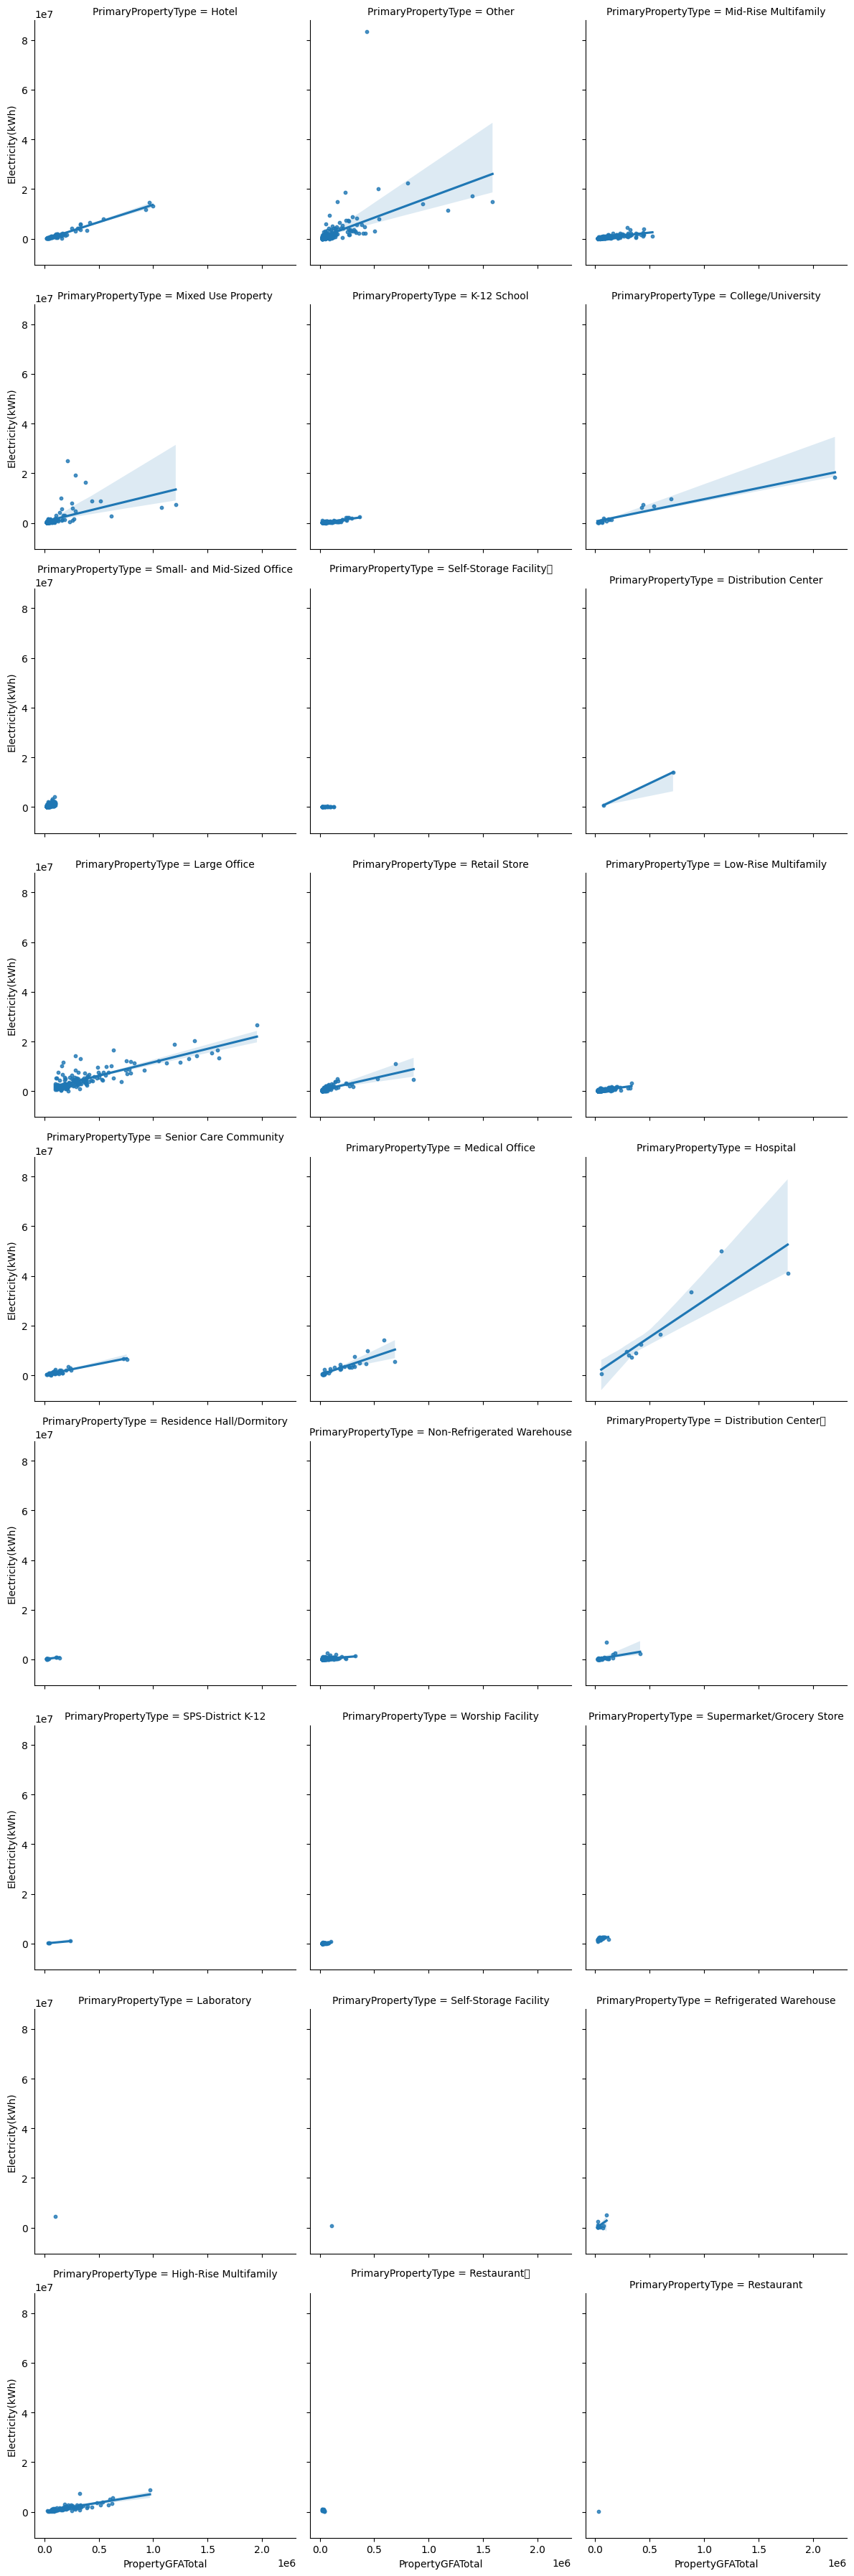

In [15]:
# Regressing GFA to Electricty consumption by property type
g = sns.FacetGrid(data=df_seattle,col='PrimaryPropertyType',col_wrap=3, height=4)
g.map(sns.regplot, 'PropertyGFATotal', 'Electricity(kWh)', scatter_kws={'s': 10})

In [16]:
high_correlation = [
    'Hotel',
    'Low-Rise Multifamily',
    'Mid-Rise Multifamily',
    'High-Rise Multifamily',
    'K-12 School',
    'College/University',
    'Large Office',
    'Retail Store'
    ]

df_seattle = df_seattle[df_seattle.PrimaryPropertyType.isin(high_correlation)] 

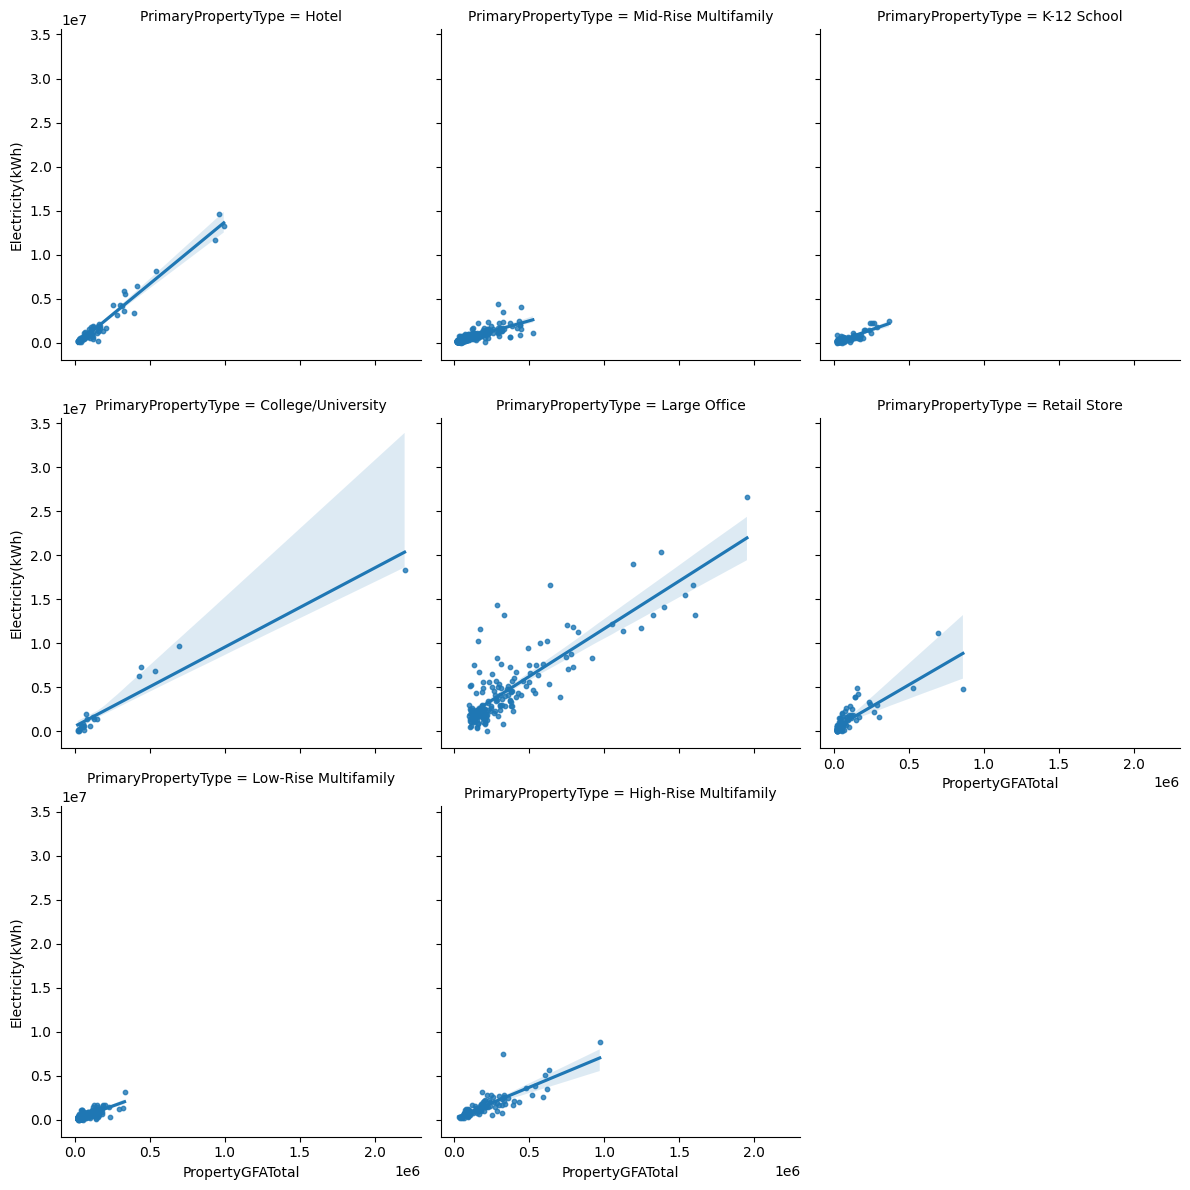

In [17]:
# Regressing GFA to Electricty consumption by filtered property type
g = sns.FacetGrid(data=df_seattle,col='PrimaryPropertyType',col_wrap=3, height=4)
g.map(sns.regplot, 'PropertyGFATotal', 'Electricity(kWh)', scatter_kws={'s': 10})

1952220

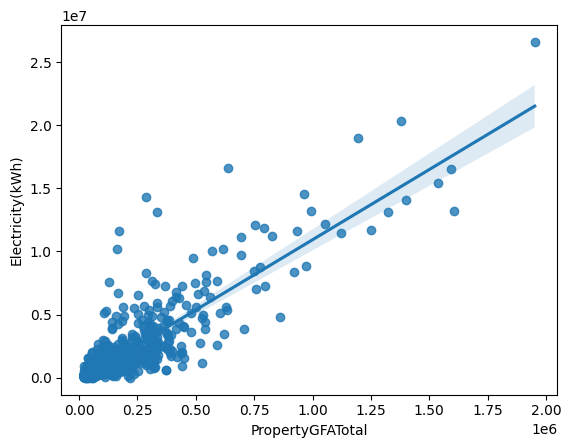

In [18]:
import seaborn as sns

# Filter the DataFrame for 'College/University' property type
df_college_university = df_seattle[df_seattle['PrimaryPropertyType'] == 'College/University']
df_college_university = df_seattle[df_seattle['PropertyGFATotal'] < 2200000]

# Plotting regression between 'Electricity(kWh)' and 'College/University'
sns.regplot(data=df_college_university, x='PropertyGFATotal', y='Electricity(kWh)')

df_college_university.PropertyGFATotal.max()

In [19]:
# Removing outliers for 'College/University' from the original DataFrame
df_seattle = df_seattle[~((df_seattle['PrimaryPropertyType'] == 'College/University') & (df_seattle['PropertyGFATotal'] >= 2200000))]

<Axes: xlabel='PropertyGFATotal', ylabel='Electricity(kWh)'>

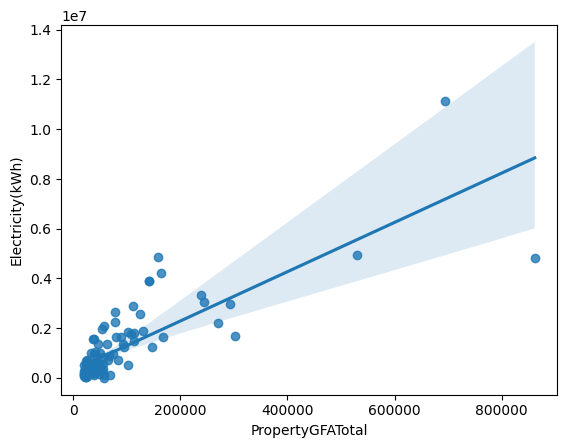

In [20]:
sns.regplot(data=df_seattle[df_seattle.PrimaryPropertyType == 'Retail Store'], x='PropertyGFATotal', y='Electricity(kWh)')

<Axes: xlabel='PropertyGFATotal', ylabel='Electricity(kWh)'>

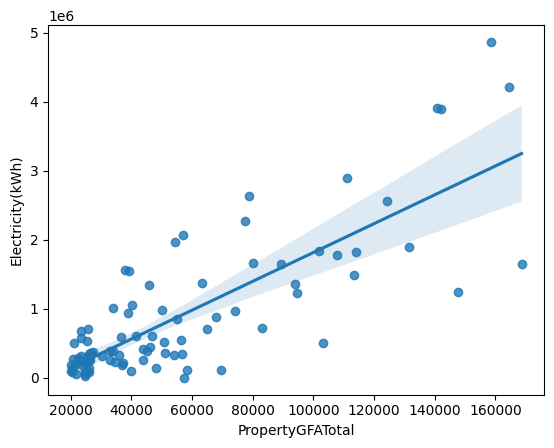

In [21]:
# Removing outliers for 'Retail Store' from the original DataFrame
df_seattle = df_seattle[~((df_seattle['PrimaryPropertyType'] == 'Retail Store') & (df_seattle['PropertyGFATotal'] >= 200000))]

sns.regplot(data=df_seattle[df_seattle.PrimaryPropertyType == 'Retail Store'], x='PropertyGFATotal', y='Electricity(kWh)')

### Encoding descriptive features 🔢

In [22]:
nan_features = ['PrimaryPropertyType','building_classification']

from sklearn.preprocessing import OrdinalEncoder

# Instantiate Ordinal Encoder
ordinal_encoder = OrdinalEncoder()

# Fit to features
df_encoded = df_seattle.copy()
ordinal_encoder.fit(df_encoded[nan_features])
display(ordinal_encoder.categories_)

# Transforming categories into ordered numbers
df_encoded[nan_features] = ordinal_encoder.transform(df_encoded[nan_features])

df_encoded

[array(['College/University', 'High-Rise Multifamily', 'Hotel',
        'K-12 School', 'Large Office', 'Low-Rise Multifamily',
        'Mid-Rise Multifamily', 'Retail Store'], dtype=object),
 array(['non_residential', 'residential'], dtype=object)]

,PrimaryPropertyType,NumberofFloors,PropertyGFATotal,Electricity(kWh),building_classification
0,2.0,12.0,88434,1080307.0,0.0
1,2.0,11.0,103566,1144563.0,0.0
2,2.0,41.0,961990,14583930.0,0.0
3,2.0,10.0,61320,811521.0,0.0
4,2.0,18.0,119890,1777841.0,0.0
...,...,...,...,...,...
3335,5.0,4.0,44650,334979.0,1.0
3336,6.0,7.0,42393,325705.0,1.0
3337,1.0,40.0,319481,1690364.0,1.0
3338,5.0,3.0,48230,227744.0,1.0


### Scaling the numerical columns

In [40]:
from sklearn.preprocessing import StandardScaler

# instantiate scaler
s_scaler = StandardScaler()

# instantiate scaled df before transform
df_scaled = df_encoded.copy()

# define numerical features 
numerical_features = list(df_scaled.columns)
numerical_features.remove('Electricity(kWh)')

# fit scaler
s_scaler.fit(df_scaled[numerical_features])

# apply tranform to features
df_scaled[numerical_features] = s_scaler.transform(df_scaled[numerical_features])

df_scaled

,PrimaryPropertyType,NumberofFloors,PropertyGFATotal,Electricity(kWh),building_classification
0,-1.953561,1.067487,-0.044354,1080307.0,-2.115237
1,-1.953561,0.899623,0.058392,1144563.0,-2.115237
2,-1.953561,5.935549,5.887067,14583930.0,-2.115237
3,-1.953561,0.731758,-0.228457,811521.0,-2.115237
4,-1.953561,2.074672,0.169232,1777841.0,-2.115237
...,...,...,...,...,...
3335,0.146319,-0.275427,-0.341646,334979.0,0.472760
3336,0.846280,0.228166,-0.356971,325705.0,0.472760
3337,-2.653522,5.767684,1.524449,1690364.0,0.472760
3338,0.146319,-0.443291,-0.317338,227744.0,0.472760


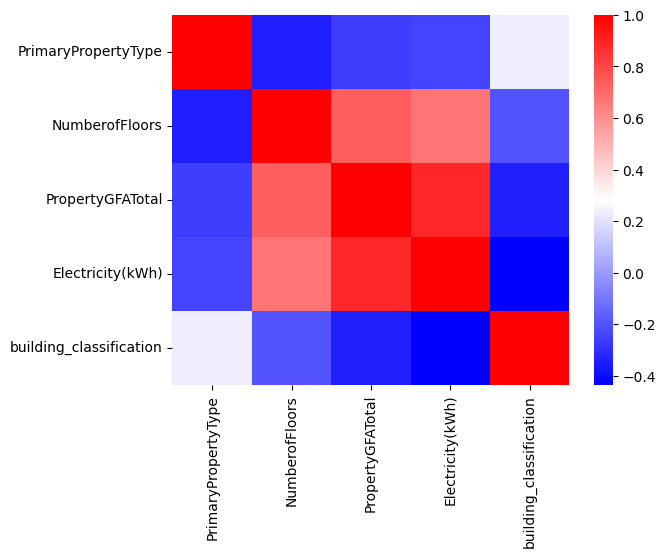

In [43]:
# Heatmap of pairwise correlations
correlation_matrix = df_scaled.corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, xticklabels=column_names, yticklabels=column_names,cmap= "bwr");

In [45]:
# try dropping building classification and primary property type?

,feature_1,feature_2,correlation
1,PrimaryPropertyType,NumberofFloors,-0.349314
2,PrimaryPropertyType,PropertyGFATotal,-0.260324
3,PrimaryPropertyType,Electricity(kWh),-0.242181
4,PrimaryPropertyType,building_classification,0.237859
5,NumberofFloors,PrimaryPropertyType,-0.349314
7,NumberofFloors,PropertyGFATotal,0.734784
8,NumberofFloors,Electricity(kWh),0.672549
9,NumberofFloors,building_classification,-0.199499
10,PropertyGFATotal,PrimaryPropertyType,-0.260324
11,PropertyGFATotal,NumberofFloors,0.734784


### Running the model

In [42]:
# import model type
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Instantiate model 
sgd_regressor = SGDRegressor()

# define x and y 
features = list(df_scaled.columns)
features.remove('Electricity(kWh)')

X = df_scaled[features]
y = df_scaled['Electricity(kWh)']

scores = cross_val_score(sgd_regressor, X, y, cv=5)
scores.mean()

0.48233026515007243

In [25]:
# make first prediction
new_building = pd.DataFrame({
    'PrimaryPropertyType': 'Hotel',
    'NumberofFloors': 12,
    'PropertyGFATotal': 335066,
    'building_classification': 'non_residential' 
    }, index=[0])

new_building

,PrimaryPropertyType,NumberofFloors,PropertyGFATotal,building_classification
0,Hotel,12,335066,non_residential


In [26]:
# train model 
sgd_regressor.fit(X, y)

# Encode Features
new_building[nan_features] = ordinal_encoder.transform(new_building[nan_features])

# Scale the new data using the same scaler used for the training data
new_building[numerical_features] = s_scaler.transform(new_building[numerical_features])


new_building


,PrimaryPropertyType,NumberofFloors,PropertyGFATotal,building_classification
0,-1.953561,1.067487,1.630271,-2.115237


In [27]:
# predict new_building
prediction = sgd_regressor.predict(new_building)
print(f'prediction: {prediction[0]}')

prediction: 4088349.5426211515


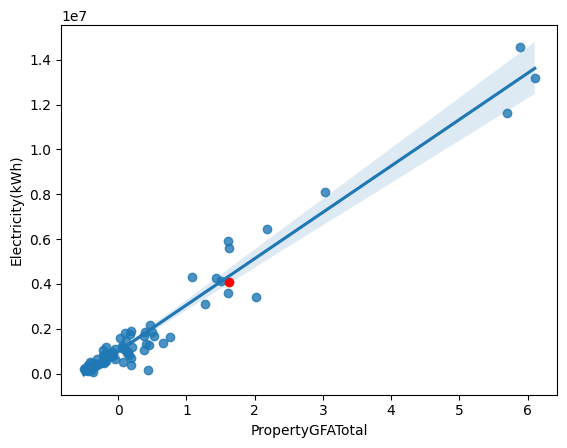

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

hotel_code = df_scaled.PrimaryPropertyType.unique()[0]

# Filter the data for a specific property type
property_type = hotel_code # Replace with the property type you want to visualize
subset_data = df_scaled[df_scaled['PrimaryPropertyType'] == property_type]

# Create a regression plot
sns.regplot(data=subset_data, x='PropertyGFATotal', y='Electricity(kWh)')

# Scatter plot for predicted values
plt.scatter(new_building['PropertyGFATotal'], prediction, color='red', label='Predicted')


`dont forget to convert gfa units to m2`

In [29]:
# test with large office
# make first prediction
office_building = pd.DataFrame({
    'PrimaryPropertyType': 'Large Office',
    'NumberofFloors': 12,
    'PropertyGFATotal': 335066,
    'building_classification': 'non_residential' 
    }, index=[0])

# Encode Features
office_building[nan_features] = ordinal_encoder.transform(office_building[nan_features])

# Scale the office data using the same scaler used for the training data
office_building[numerical_features] = s_scaler.transform(office_building[numerical_features])

# predict office_building
prediction = sgd_regressor.predict(office_building)

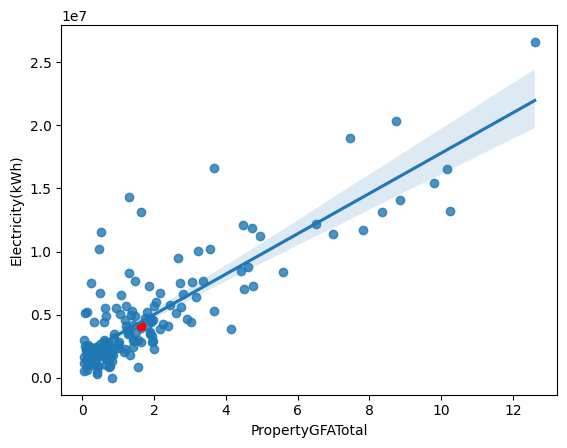

In [30]:
office_code = office_building.PrimaryPropertyType[0]

# Filter the data for a specific property type
property_type = office_code # Replace with the property type you want to visualize
subset_data = df_scaled[df_scaled['PrimaryPropertyType'] == property_type]

# Create a regression plot
sns.regplot(data=subset_data, x='PropertyGFATotal', y='Electricity(kWh)')

# Scatter plot for predicted values
plt.scatter(new_building['PropertyGFATotal'], prediction, color='red', label='Predicted')



In [31]:
prediction

array([4139277.34228194])

## 2. `get_water_demmand`

this method should return a dataframe that has the following features:\
`building`, `area`, `asset`, `potable_water_demmand`

In [32]:
df_model.isna().sum()

ID          0
Typology    0
Area        0
Plot        0
Building    0
Colour      0
dtype: int64